Install and import packages

In [1]:
# install Python OT
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 12.6 MB/s eta 0:00:00


In [2]:
! pip install kagglehub

In [3]:
import numpy as np # linear algebra
import cv2
import pandas as pd # data processing
import scipy as sp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

import kagglehub

import ot

Get templates.
We will use Point Cloud Mnist 2D for our experiments.

In [4]:
# Download latest version
path = kagglehub.dataset_download("cristiangarcia/pointcloudmnist2d",)

100%|██████████| 32.6M/32.6M [00:00<00:00, 43.6MB/s]

Extracting files...


In [5]:
df = pd.read_csv(path+"/test.csv")
Data = df[df.columns[1:]].to_numpy()
label = df[df.columns[0]].to_numpy()
Data = Data.reshape(Data.shape[0], -1, 3)

In [6]:
digit_indices = [np.where(label == digit)[0].tolist() for digit in range(10)]

In [7]:
## Templates (matrix, measure)

digit = 3   # Pick a digit from 0 to 9

n_temp = 10   # Number of templates

measure_temp_list = []   #list of template measures
matrix_temp_list = []   #list of template dissimilarity matrices
ind_temp_list = []   #list of tamplate indices from dataset

for s in range(n_temp):
    ind = digit_indices[digit][np.random.randint(len(digit_indices[digit]))]
    ind_temp_list.append(ind)

    p_s = Data[ind,:,2]
    valid_indices = np.where(p_s != -1)[0]
    p_s = p_s[valid_indices]
    p_s = p_s / float(p_s.sum())
    measure_temp_list.append(p_s)

    C_s = Data[ind, valid_indices, :2]
    C_s = C_s-C_s.mean(0)[np.newaxis,:]
    dist_matrix_s = sp.spatial.distance.cdist(C_s, C_s)
    matrix_temp_list.append(dist_matrix_s)

Generate vector of weights of your barycenter.

---



In [8]:
lambdas_list = np.random.rand(n_temp)
lambdas_list = lambdas_list/lambdas_list.sum()

Synthesize a Barycenter using POT.

In [9]:
M = 300 # Dimension of output barycentric matrix is MxM.

#q = np.ones(M) / M   #Uniform target probability vector
b = np.random.rand(M)
b = b/b.sum()   # Random target probability vector

B =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas_list)  #Synthesize barycenter matrix

Check if the computed barycenyter is a fixed point of the iterative forward algorithm.

In [10]:
pi_list = []
F_list = []
Q = (b.reshape(-1,1) @ b.reshape(1,-1))
Q = 1. / Q

for s in range(n_temp):
    pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s],B,measure_temp_list[s],b)
    pi_list.append(pi_s)
    F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)
    F_list.append(F_s)


# One Fix point iteration
B_fp = np.zeros_like(B)
for s in range(n_temp):
    B_fp += lambdas_list[s] * F_list[s]

## Compare
gromov_distance = ot.gromov.gromov_wasserstein(B, B_fp, b, b, log=True)[1]
gw_dist = gromov_distance['gw_dist']
print(f'GW-error: {gw_dist}')

GW-error: -1.3433546104563316e-14


Visualize by using MDS embedding

In [11]:
## Create an MDS instance
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

In [12]:
## Fit and transform the distance matrix
points_B = mds.fit_transform(B)
points_B_fp = mds.fit_transform(B_fp)

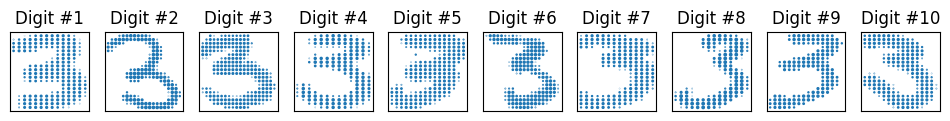

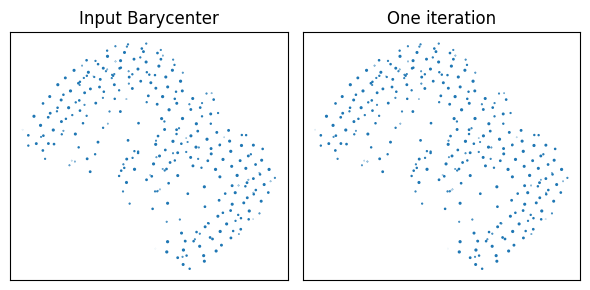

In [13]:
## Plot templates
fig, axes = plt.subplots(1, n_temp, figsize=(12, 6))
axes = axes.flatten()

for i, ind in enumerate(ind_temp_list):
    a = Data[ind,:,2]
    X = Data[ind,a!=-1,:2]
    X = X-X.mean(0)[np.newaxis,:]
    X -= X.min(axis=0)
    X /= X.max(axis=0)
    a = a[a!=-1]
    a = a/float(a.sum())
    axes[i].scatter(X[:, 0], X[:, 1], s=a*250)
    axes[i].set_title(f'Digit #{i+1}')
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].set_xticks([])  # Remove x-axis ticks
    axes[i].set_yticks([])  # Remove y-axis ticks
    #axes[i].axis('off')

plt.show()


## Plot Barycenter and check if it is a fix point of the iteration
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].scatter(points_B[:, 0], points_B[:, 1], s=b*250)
axes[0].set_title('Input Barycenter')
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks

axes[1].scatter(points_B_fp[:, 0], points_B_fp[:, 1], s=b*250)
axes[1].set_title('One iteration')
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks

# Adjust layout to avoid overlap
plt.tight_layout()

plt.show()